In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from astropy import modeling
from astropy.modeling import models, fitting

In [51]:
def sub_npy(npy_fil, subfactor):
    
    npy = np.load(npy_fil)
    #npy = npy.T #transpose to scrunch in time rather than frequency
    npy_sub = np.flipud(np.nanmean(npy.reshape(-1, subfactor, npy.shape[1]), axis=1))

    return npy, npy_sub

In [52]:
sf = 2
npy, npy_sub = sub_npy('B_686_dm348.8.fits.npy', sf)
nchan = npy_sub.shape[0]
fres = 375 / nchan

Text(0.5, 1.0, 'Dynamic Spectrum')

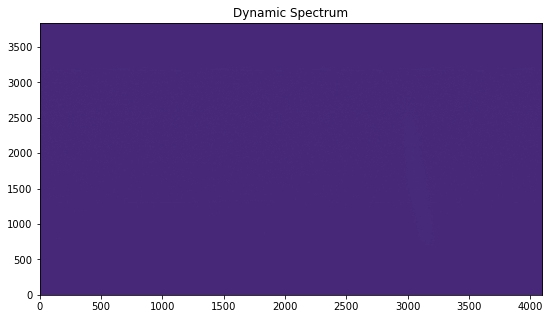

In [53]:
fig = plt.figure(figsize = (9, 5))
plt.imshow(npy_sub, aspect = 'auto', origin = 'lower')
plt.title('Dynamic Spectrum')

In [59]:
#npy_cut = npy_sub[int(4000/sf):-int(1000/sf), :] #B
npy_cut = npy_sub[:, :]
#npy_cut = npy_sub[int(2000/sf):-int(2000/sf), 250:400]

Text(0.5, 1.0, 'Cropped Dynamic Spectrum')

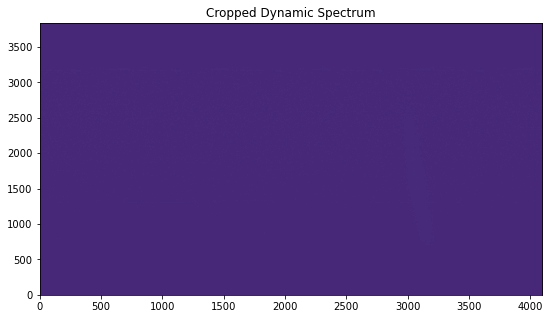

In [63]:
fig = plt.figure(figsize = (9, 5))
plt.imshow(npy_cut, aspect = 'auto', origin = 'lower')
plt.title('Cropped Dynamic Spectrum')

Text(0, 0.5, 'Arb. Intensity')

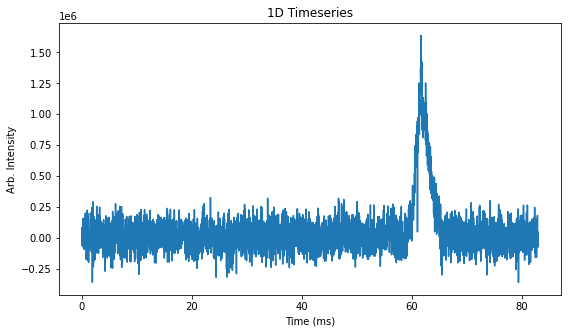

In [64]:
fig = plt.figure(figsize = (9, 5))
t = np.linspace(0, 83, len(npy.sum(0)))
plt.plot(t, npy.sum(0))
plt.title('1D Timeseries')
plt.xlabel('Time (ms)')
plt.ylabel('Arb. Intensity')

Text(0.5, 1.0, '1D Spectrum')

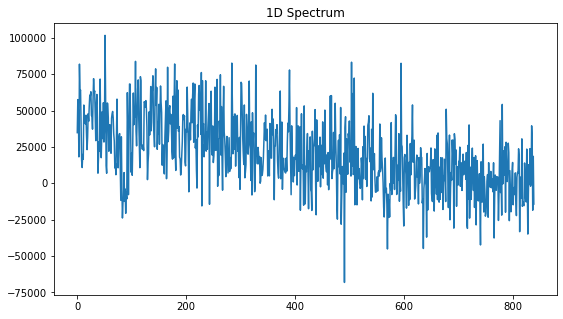

In [46]:
fig = plt.figure(figsize = (9, 5))
plt.plot(npy_cut.sum(1))
plt.title('1D Spectrum')

In [47]:
spec = npy_cut.sum(1)
acf = sig.correlate(npy_cut.sum(1), npy_cut.sum(1))

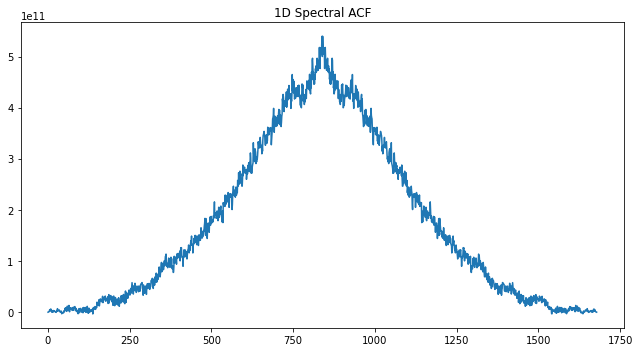

In [48]:
fig = plt.figure(figsize = (9, 5))
ax = fig.add_subplot(111)
acf[len(acf)//2] = 5e11
plt.plot(acf)
plt.title('1D Spectral ACF')
plt.tight_layout()

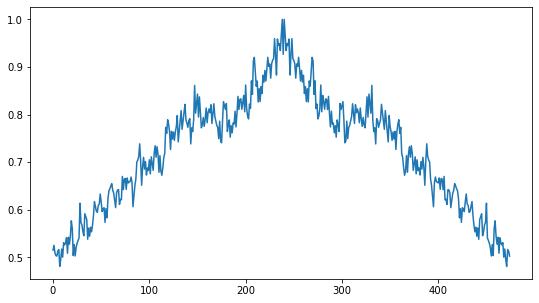

In [49]:
fig = plt.figure(figsize = (9, 5))
acf[len(acf)//2] = 5e11
acf = acf / np.max(acf)
acf = acf[600:1075]
plt.plot(acf)

In [58]:
def reduced_chi_square(fit, x, y, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/np.sqrt(np.abs(y))**2))

In [59]:
#Fit 1D Lorentzian to Timeseries

x_acf = np.linspace(0, len(acf), len(acf))
maxim_acf = np.max(acf)
std_acf = np.std(acf)
mean_acf = np.where(acf == maxim_acf)[0][0]

peaks_acf = sig.find_peaks(acf)[0]
peak_1_acf = peaks_acf[len(peaks_acf)//2]
pkwidths_acf = sig.peak_widths(acf, [peak_1_acf])[0][0]

fitter_acf = modeling.fitting.LevMarLSQFitter()
model_acf = modeling.models.Lorentz1D(amplitude=maxim_acf, x_0=mean_acf, fwhm=pkwidths_acf) + modeling.models.Lorentz1D(amplitude=maxim_acf, x_0=mean_acf, fwhm=6)
#model_acfsp = modeling.models.Gaussian1D(amplitude=1., mean=mean_acf, stddev=1.)
fitted_model_acf = fitter_acf(model_acf, x_acf, acf)
fit_acf = fitted_model_acf(x_acf)

In [60]:
print(fitted_model_acf[1].fwhm[0]*fres)

2.1575714353534217


In [61]:
#Fit Check
n_free = len(fitted_model_acf.parameters)
N = len(x_acf)
rchisq = reduced_chi_square(fitted_model_acf(x_acf), x_acf, acf, N, n_free)
print("Red. Chi Square: ", rchisq)

fwmax = fitted_model_acf[0].amplitude[0] / 2
fwm_idx = (np.abs(acf - fwmax)).argmin()
fwt_idx = np.where(acf == acf[fwm_idx])[0][0]
print('Scintillation Bandwidth: ' + str(np.abs(len(acf)//2*fres - fwt_idx*fres)) + ' MHz')

Red. Chi Square:  0.002183789453535727
Scintillation Bandwidth: 22.4609375 MHz


(-25.0, 25.0)

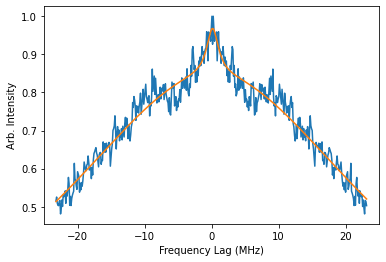

In [62]:
x_acf = np.linspace(-len(acf)//2, len(acf)//2, len(acf))
x_acf_flag = x_acf * fres
plt.plot(x_acf_flag, acf)
plt.plot(x_acf_flag, fit_acf)
plt.xlabel('Frequency Lag (MHz)')
plt.ylabel('Arb. Intensity')
plt.xlim(-25, 25)